In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ft2font
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import itertools
from itertools import zip_longest
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse import dok_matrix
from scipy.sparse import block_diag
from scipy.sparse.linalg import eigsh
import scipy.linalg as la
import os
import Hamiltonian_definition as HD
from datetime import datetime

In [40]:
save_path = "/home/costanza/UNIVERSITÀ/secondo semestre/MOLTI CORPI/dati/2x2/"
Lx,Ly = 2,2 # lattice dim
L=Lx*Ly
dim = 2**(Lx*Ly)
J1,J2 = 1.0,0.0


### Lattice definition

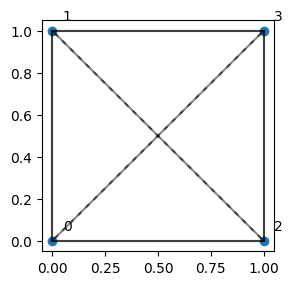

0 --> Nearest neighbors: [2, 1]  -- Next neighbor: [3]
1 --> Nearest neighbors: [3, 0]  -- Next neighbor: [2]
2 --> Nearest neighbors: [0, 3]  -- Next neighbor: [1]
3 --> Nearest neighbors: [1, 2]  -- Next neighbor: [0]


In [19]:
coor = HD.generate_lattice(Lx,Ly)
neighbors_indices = HD.index_nn(coor,Lx,Ly)
diag_indices = HD.index_nnn(coor,Lx,Ly)

HD.plot_lattice(coor,neighbors_indices,diag_indices)

### Hamiltonian definition

In [22]:
# HAMILTONIAN
def flip(state,i,j): #flippa lo spin degli indici i e j
    return state ^ (2**i + 2**j) # ^==xor

def Hamiltonian(J1, J2, state):
    result = []
    seen_states_1 = set()  # Per evitare duplicati
    seen_states_2 = set() 
    seen_states_d = set() 
    
    coeff_nn = 0
    coeff_nnn = 0
    for i in range(Lx*Ly):
        n = (state & 2**i)/2**i #extract bit at position i --> 0 or 1 --> poi (2n-1)/2 per avere -1/2, +1/2
        # print(f"* sito {i} --> spin={n}")
        
        nn_x = neighbors_indices[i][0] #nn dx
        nn_y = neighbors_indices[i][1] #nn up
        nn_d = diag_indices[i][0] #nnn

        nn_1 = (state & 2**nn_x)/2**nn_x
        nn_2 = (state & 2**nn_y)/2**nn_y
        coeff_nn += (2*n-1)*(2*nn_1-1)/8 + (2*n-1)*(2*nn_2-1)/8 # sarebbe (2*n-1)/2 * (2*nn-1)/2 
        if n!=nn_1 : 
            new_state_1 = flip(state,i,nn_x)
            if new_state_1 not in seen_states_1:
                result.append([J1/2,new_state_1])
                seen_states_1.add(new_state_1)
        if n!=nn_2 : 
            new_state_2 = flip(state,i,nn_y)
            if new_state_2 not in seen_states_2:
                result.append([J1/2,new_state_2])
                seen_states_2.add(new_state_2)
        
        nnn = (state & 2**nn_d)/2**nn_d
        # print(f"sito diagonale vicino {nn_d} --> spin={nnn}")
        coeff_nnn += (2*n-1)*(2*nnn-1)/8 #1/2 in più perchè i vicini in diagonale li sto contando due volte
        if n!=nnn : 
            new_state_d = flip(state,i,nn_d)
            if new_state_d not in seen_states_d:
                result.append([J2/2,new_state_d])
                seen_states_d.add(new_state_d)
                # print(f"stato iniziale {state}--> stato finale {new_state_d}")

    result.append([J1*coeff_nn+J2*coeff_nnn, state])
    # print(result)
    return result 

In [23]:
#MATRICE DIAGONALE A BLOCCHI
L=Lx*Ly
def build_basisN(L,N): #L=Lx*Ly number of sites, N number of spin up in the sector
    basisN = []
    for n in range(2**L):
        particle_count = bin(n).count('1') #count the 1 in n
        if particle_count == N:
            basisN.append(n) #check if n belongs to the N sector
    return basisN


def build_HN(L,N,J1,J2):
    basisN = build_basisN(L,N)
    dimN = len(basisN) #dimension of the subspace S_N
    HN = dok_matrix((dimN,dimN)) #crea matrice vuota sparsa

    for b,n in enumerate(basisN): #b index, n binary state
        # print("--------------------------")
        # print(f"stato {n}")
        output = Hamiltonian(J1,J2,n) #H|n>
        for coeff,m in output:
            try:
                a = basisN.index(m)
                HN[a,b]+=coeff
            except ValueError:
                continue
    return HN.tocsr() #csr


def H_diag_block(L,J1,J2):
    blocks = []
    for N in range(L+1):
        basisN = build_basisN(L,N)
        if len(basisN) > 0:
            HN = build_HN(L,N,J1,J2)
            blocks.append(HN)
    H = block_diag(blocks, format="csr")
    return H



## Diagonalization (exact)

In [45]:
angles = [i*np.pi/16 for i in range(9)]
theta = angles[1:-1]

J1_val=np.sin(theta)
J2_val=np.cos(theta)

for j in range(len(J1_val)):
    J1 = J1_val[j]
    J2 = J2_val[j]
    print("-------------------------------")
    print(f'J1={round(J1,2)}_J2={round(J2,2)}')

    row,col,data = [],[],[]   #matrice sparsa
    for i in range(dim):
        
        H = Hamiltonian(J1,J2,i)
        for value,j in H:
            row.append(i)      
            col.append(j)      
            data.append(value) #appende value in posizione (i,j) 
    sparse_matrix = csr_matrix((data,(row,col)),shape=(dim,dim))

    matrix = sparse_matrix.toarray() 

    eigvals, eigvecs = la.eigh(matrix)
    print(f"finito di diagonalizzare HN_{N} alle", datetime.now())
    print("")

    folder_name = f"J1={round(J1,2)}_J2={round(J2,2)}/"
    full_path = save_path + folder_name
    os.makedirs(full_path, exist_ok=True)

    np.save(full_path+f"eigvals", eigvals)
    np.save(full_path+f"eigvecs", eigvecs)



-------------------------------
J1=0.2_J2=0.98
finito di diagonalizzare HN_2 alle 2025-05-15 15:30:13.505668

-------------------------------
J1=0.38_J2=0.92
finito di diagonalizzare HN_2 alle 2025-05-15 15:30:13.510557

-------------------------------
J1=0.56_J2=0.83
finito di diagonalizzare HN_2 alle 2025-05-15 15:30:13.515915

-------------------------------
J1=0.71_J2=0.71
finito di diagonalizzare HN_2 alle 2025-05-15 15:30:13.520616

-------------------------------
J1=0.83_J2=0.56
finito di diagonalizzare HN_2 alle 2025-05-15 15:30:13.524992

-------------------------------
J1=0.92_J2=0.38
finito di diagonalizzare HN_2 alle 2025-05-15 15:30:13.529415

-------------------------------
J1=0.98_J2=0.2
finito di diagonalizzare HN_2 alle 2025-05-15 15:30:13.533891



### diag one value of J1,J2

[0.19634954084936207, 0.5890486225480862, 0.9817477042468103, 1.3744467859455345]


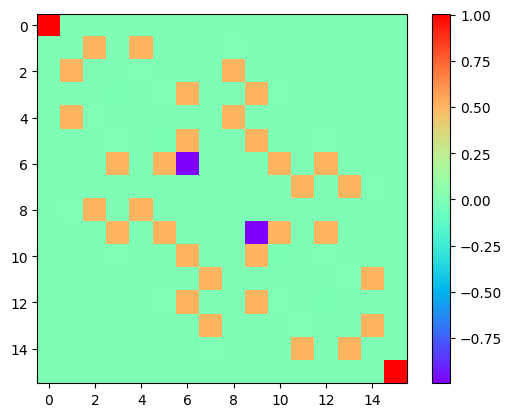

In [ ]:
#matrice sparsa
row,col,data = [],[],[]
for i in range(dim):
    H = Hamiltonian(J1,J2,i)
    for value,j in H:
        row.append(i)      
        col.append(j)      
        data.append(value) #appende value in posizione (i,j) 
sparse_matrix = csr_matrix((data,(row,col)),shape=(dim,dim))
#print(sparse_matrix.toarray())

# plt.figure(figsize=(3,3))
# plt.spy(sparse_matrix, markersize=0.5)
# plt.show()

matrix = sparse_matrix.toarray() 

# #TOTAL MATRIX
# total_matrix = np.array(matrix)
# np.save("matrix.npy", matrix)
# for row in matrix:
#     print("[", " ".join(f"{i:4}" for i in row), "]")

# Plot della matrice con la colormap
plt.imshow(matrix, cmap='rainbow')
plt.colorbar()  # Barra dei colori
plt.show()

eigvals, eigvecs = la.eigh(matrix)

folder_name = f"J1={round(J1,2)}_J2={round(J2,2)}/"
full_path = save_path + folder_name
os.makedirs(full_path, exist_ok=True)

np.save(full_path+f"eigvals", eigvals)
np.save(full_path+f"eigvecs", eigvecs)


## Some (old) tests

### sparse matrix and matrix (total)

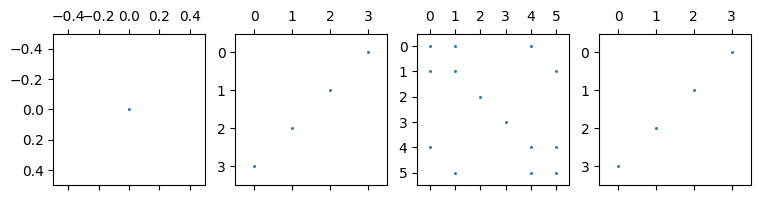

[ -0.5  0.5  0.0  0.0  0.5  0.0 ]
[  0.5 -0.5  0.0  0.0  0.0  0.5 ]
[  0.0  0.0  0.5  0.0  0.0  0.0 ]
[  0.0  0.0  0.0  0.5  0.0  0.0 ]
[  0.5  0.0  0.0  0.0 -0.5  0.5 ]
[  0.0  0.5  0.0  0.0  0.5 -0.5 ]


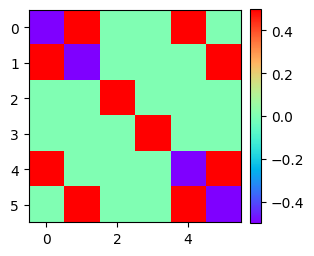

In [8]:
fig, axes = plt.subplots(1,4, figsize=(9, 6)) 
matrix_N = []
for N, ax in enumerate(axes.flat[:Lx*Ly]):
    HN = build_HN(L,N,J1,J2)
    #print(HN.shape)
    ax.spy(HN, markersize=1)
    HN_matrix = HN.toarray()
    matrix_N.append(HN_matrix)
plt.show()


for row in matrix_N[2]:
    print("[", " ".join(f"{i:4}" for i in row), "]")
        
# Plot della matrice con la colormap
fig, ax = plt.subplots(figsize=(3,3))  
im = ax.imshow(matrix_N[2], cmap='rainbow')  
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10) 
plt.show()


### Sz=0

[  0.0  0.0  0.5  0.5  0.0  0.0 ]
[  0.0  0.0  0.5  0.5  0.0  0.0 ]
[  0.5  0.5 -1.0  0.0  0.5  0.5 ]
[  0.5  0.5  0.0 -1.0  0.5  0.5 ]
[  0.0  0.0  0.5  0.5  0.0  0.0 ]
[  0.0  0.0  0.5  0.5  0.0  0.0 ]


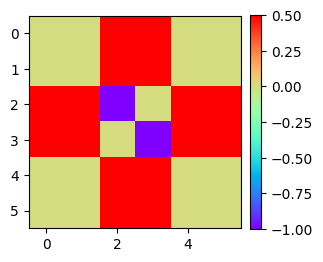

In [13]:
N=2 #2 spin up
HN = build_HN(L,N,J1,J2)
HN_matrix = HN.toarray()

for row in HN_matrix:
    print("[", " ".join(f"{i:4}" for i in row), "]")
        
# Plot della matrice con la colormap
fig, ax = plt.subplots(figsize=(3,3))  
im = ax.imshow(HN_matrix, cmap='rainbow')  
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10) 
plt.show()

GS [ 0.28867513  0.28867513 -0.57735027 -0.57735027  0.28867513  0.28867513]
autovalori [-2.00000000e+00 -1.00000000e+00  0.00000000e+00  2.22044605e-16
  3.75932965e-16  1.00000000e+00]
nearest neighbor correlation -0.1666666666666667
next neighbor correlation 0.08333333333333337


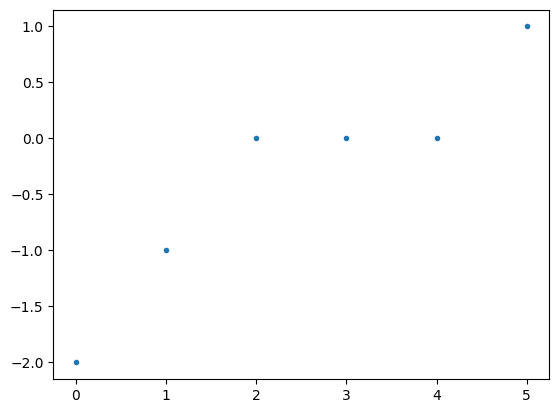

In [15]:
eigvals, eigvecs = la.eigh(HN_matrix)
plt.plot(eigvals, '.')
print("GS", eigvecs[:, 0])
print("autovalori", eigvals)

psi1 = eigvecs[:,0]
psi2 = eigvecs[:,0]

N=2
SzSz_nn_exval, SzSz_nnn_exval = HD.spin_corr(Lx,Ly,psi1,psi2,N,neighbors_indices,diag_indices)

print("nearest neighbor correlation", SzSz_nn_exval)
print("next neighbor correlation", SzSz_nnn_exval)


### matrice diagonale a blocchi

--------------------------
stato 0
* sito 0 --> spin=0.0
sito diagonale vicino 3 --> spin=0.0
* sito 1 --> spin=0.0
sito diagonale vicino 2 --> spin=0.0
* sito 2 --> spin=0.0
sito diagonale vicino 1 --> spin=0.0
* sito 3 --> spin=0.0
sito diagonale vicino 0 --> spin=0.0
[[1.0, 0]]
--------------------------
stato 1
* sito 0 --> spin=1.0
sito diagonale vicino 3 --> spin=0.0
stato iniziale 1--> stato finale 8
* sito 1 --> spin=0.0
sito diagonale vicino 2 --> spin=0.0
* sito 2 --> spin=0.0
sito diagonale vicino 1 --> spin=0.0
* sito 3 --> spin=0.0
sito diagonale vicino 0 --> spin=1.0
[[0.5, 4], [0.5, 2], [0.0, 8], [0.0, 1]]
--------------------------
stato 2
* sito 0 --> spin=0.0
sito diagonale vicino 3 --> spin=0.0
* sito 1 --> spin=1.0
sito diagonale vicino 2 --> spin=0.0
stato iniziale 2--> stato finale 4
* sito 2 --> spin=0.0
sito diagonale vicino 1 --> spin=1.0
* sito 3 --> spin=0.0
sito diagonale vicino 0 --> spin=0.0
[[0.5, 1], [0.5, 8], [0.0, 4], [0.0, 2]]
------------------------

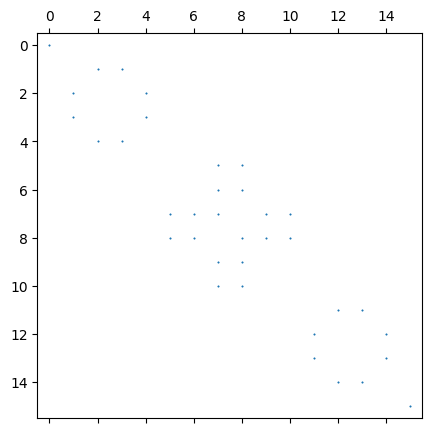

[  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ]
[  0.0  0.0  0.5  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ]
[  0.0  0.5  0.0  0.0  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ]
[  0.0  0.5  0.0  0.0  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ]
[  0.0  0.0  0.5  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ]
[  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.5  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ]
[  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.5  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ]
[  0.0  0.0  0.0  0.0  0.0  0.5  0.5 -1.0  0.0  0.5  0.5  0.0  0.0  0.0  0.0  0.0 ]
[  0.0  0.0  0.0  0.0  0.0  0.5  0.5  0.0 -1.0  0.5  0.5  0.0  0.0  0.0  0.0  0.0 ]
[  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.5  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ]
[  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.5  0.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ]
[  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.5  0.5  0.0

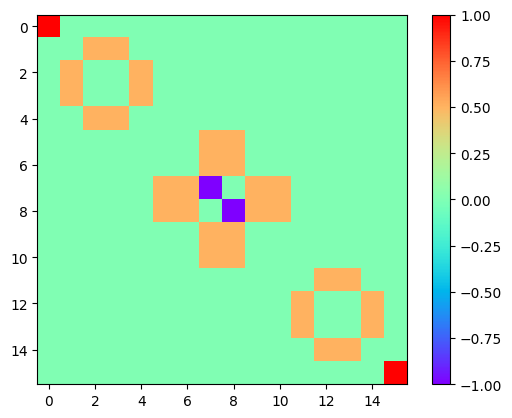

In [12]:
diag_block_matrix = H_diag_block(L,J1,J2)
plt.figure(figsize=(5,5))
plt.spy(diag_block_matrix, markersize=0.5)
plt.show()

#TOTAL DIAG BLOCK MATRIX
dense_matrix = diag_block_matrix.toarray() 
np.save("block diag matrix.npy", diag_block_matrix)
for row in dense_matrix:
    print("[", " ".join(f"{i:4}" for i in row), "]")

# Plot della matrice con la colormap
plt.imshow(dense_matrix, cmap='rainbow')
plt.colorbar()  # Barra dei colori
plt.show()

## Reading data

/tmp/ipykernel_18077/2295944260.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap("winter")


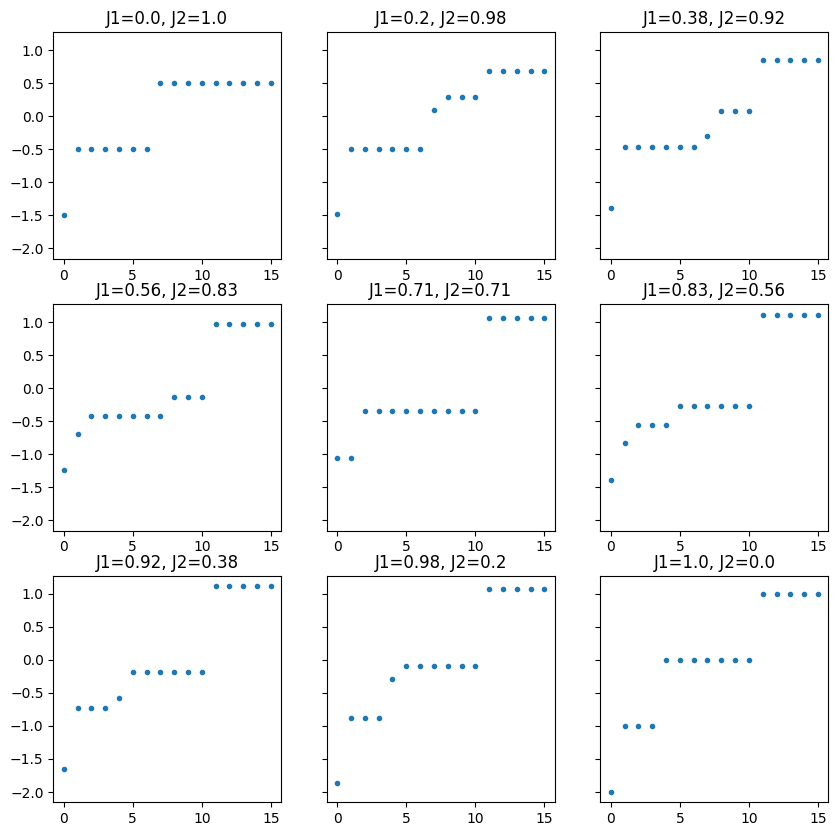

In [57]:
folder = ["J1=0.0_J2=1.0/", "J1=0.2_J2=0.98/","J1=0.38_J2=0.92/",
          "J1=0.56_J2=0.83/", "J1=0.71_J2=0.71/", "J1=0.83_J2=0.56/", 
          "J1=0.92_J2=0.38/", "J1=0.98_J2=0.2/", "J1=1.0_J2=0.0/"]
all_theta = [i*np.pi/16 for i in range(9)]

eigvals = []
fig, axes = plt.subplots(3,3, figsize=(10, 10), sharey=True)
for F, ax in enumerate(axes.flatten()):
    a = 0
    colormap = get_cmap("winter")
    colors = colormap(np.linspace(0, 1, 9))

    a = np.load(save_path+folder[F]+f"eigvals.npy")
    eigvals.append(a)
   
    J1 = np.sin(all_theta[F])
    J2 = np.cos(all_theta[F])
    ax.plot(a,'.')
    ax.set_title(f'J1={round(J1,2)}, J2={round(J2,2)}')

plt.show()

eigvals = np.array(eigvals).T

(16, 9)


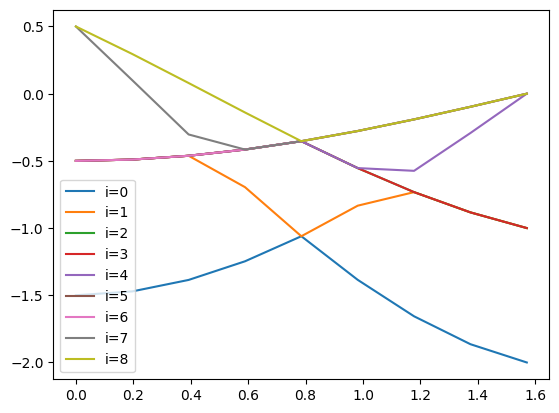

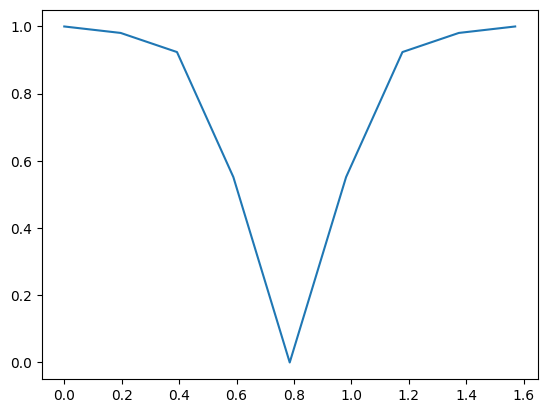

In [64]:
print(eigvals.shape)
for i in range(len(all_theta)):
    plt.plot(all_theta, eigvals[i], label=f'i={i}')
    plt.legend()
plt.show()

plt.plot(all_theta, eigvals[1]-eigvals[0])

# Correlazioni

GS [ 0.28867513  0.28867513 -0.57735027 -0.57735027  0.28867513  0.28867513]
autovalori [-2.00000000e+00 -1.00000000e+00  0.00000000e+00  2.22044605e-16
  3.75932965e-16  1.00000000e+00]
[  0.0  0.0  0.5  0.5  0.0  0.0 ]
[  0.0  0.0  0.5  0.5  0.0  0.0 ]
[  0.5  0.5 -1.0  0.0  0.5  0.5 ]
[  0.5  0.5  0.0 -1.0  0.5  0.5 ]
[  0.0  0.0  0.5  0.5  0.0  0.0 ]
[  0.0  0.0  0.5  0.5  0.0  0.0 ]


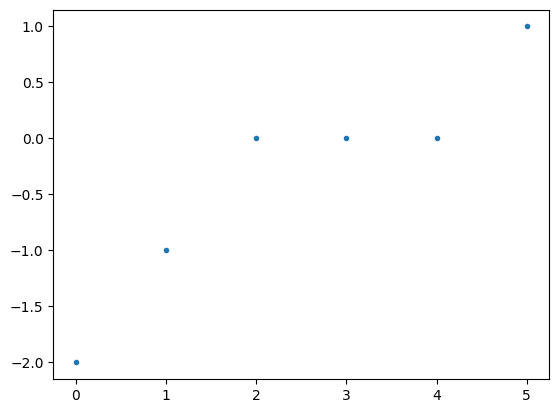

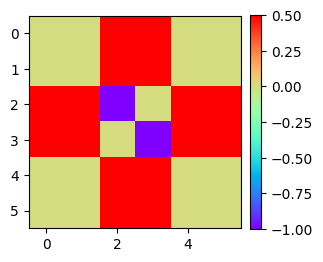

In [17]:
#Sz=0
N=2 #2 spin up
HN = build_HN(L,N,J1,J2)
HN_matrix = HN.toarray()

eigvals, eigvecs = la.eigh(HN_matrix)
plt.plot(eigvals, '.')
print("GS", eigvecs[:, 0])
print("autovalori", eigvals)

for row in HN_matrix:
    print("[", " ".join(f"{i:4}" for i in row), "]")
        
# Plot della matrice con la colormap
fig, ax = plt.subplots(figsize=(3,3))  
im = ax.imshow(HN_matrix, cmap='rainbow')  
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10) 
plt.show()

(0,0), szsz=0.25000000000000006, s+s-=0.5000000000000001, s-s+=0.5000000000000001
(0,1), szsz=-0.16666666666666657, s+s-=-0.33333333333333315, s-s+=-0.33333333333333315
(0,2), szsz=-0.16666666666666685, s+s-=-0.3333333333333336, s-s+=-0.3333333333333336
(0,3), szsz=0.08333333333333337, s+s-=0.16666666666666669, s-s+=0.16666666666666669
i=0, j=0, corr=0.7500000000000002
i=0, j=1, corr=-0.4999999999999997
i=0, j=2, corr=-0.5000000000000004
i=0, j=3, corr=0.25000000000000006
i=1, j=0, corr=-0.4999999999999997
i=1, j=1, corr=0.7500000000000002
i=1, j=2, corr=0.25000000000000006
i=1, j=3, corr=-0.5000000000000004
i=2, j=0, corr=-0.5000000000000004
i=2, j=1, corr=0.25000000000000006
i=2, j=2, corr=0.7500000000000002
i=2, j=3, corr=-0.4999999999999997
i=3, j=0, corr=0.25000000000000006
i=3, j=1, corr=-0.5000000000000004
i=3, j=2, corr=-0.4999999999999997
i=3, j=3, corr=0.7500000000000002
(0,0), szsz=0.25000000000000006, s+s-=0.5000000000000001, s-s+=0.5000000000000001
(0,1), szsz=-0.166666666

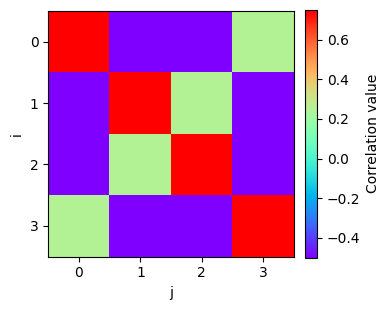

In [16]:

GS = eigvecs[:, 0]
L = Lx * Ly
correlations = HD.compute_sisj_correlations(GS, N, L)
for i in range(4):
    for j in range(4):
        print(f'i={i}, j={j}, corr={correlations[i,j]}')

SzSz_nn_exval, SzSz_nnn_exval = HD.sisj_mean(GS,N,L,neighbors_indices,diag_indices)
print("nearest neighbor correlation", SzSz_nn_exval)
print("next neighbor correlation", SzSz_nnn_exval)

# Plot
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(correlations, cmap='rainbow')
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Correlation value', fontsize=10)
ax.set_xlabel('j')
ax.set_ylabel('i')
ax.set_yticks([0, 1, 2, 3])
plt.tight_layout()
plt.show()



# Prove 

### eign values

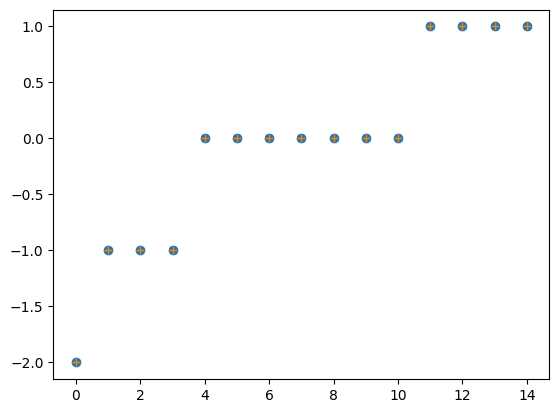

In [13]:

#sparse_matrix MATRICE (sparsa)
#diag_block_matrix MATRICE DIAGONALE A BLOCCHI (sparsa)
vals, vecs = eigsh(sparse_matrix, k=15, which='SA') #LM Largest Magnitude, SM Smallest Magnitud, LA Largest Algebric, SA Smallest Algebric
vals_diag, vecs_diag = eigsh(diag_block_matrix, k=15, which='SA') #LM Largest Magnitude, SM Smallest Magnitud, LA Largest Algebric, SA Smallest Algebric

plt.plot(vals, "o")
plt.plot(vals_diag, "+")

In [14]:
print(vals[0])

-2.0


In [15]:
print(np.round(vecs[0],3))
print(bin(13), bin(12))

[-0.    -0.    -0.     0.    -0.     0.     0.     0.     0.    -0.
  0.     0.51  -0.642  0.117 -0.323]
0b1101 0b1100


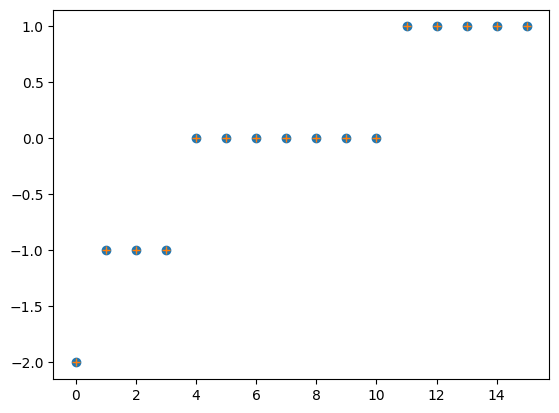

In [16]:
eigvals, eigvecs = la.eigh(matrix)
eigvals_block, eigvecs_block = la.eigh(dense_matrix) #a blocchi

plt.plot(eigvals, "o")
plt.plot(eigvals_block, "+")

--------------------------
stato 1
* sito 0 --> spin=1.0
sito diagonale vicino 3 --> spin=0.0
stato iniziale 1--> stato finale 8
* sito 1 --> spin=0.0
sito diagonale vicino 2 --> spin=0.0
* sito 2 --> spin=0.0
sito diagonale vicino 1 --> spin=0.0
* sito 3 --> spin=0.0
sito diagonale vicino 0 --> spin=1.0
[[0.5, 4], [0.5, 2], [0.5, 8], [0.0, 1]]
--------------------------
stato 2
* sito 0 --> spin=0.0
sito diagonale vicino 3 --> spin=0.0
* sito 1 --> spin=1.0
sito diagonale vicino 2 --> spin=0.0
stato iniziale 2--> stato finale 4
* sito 2 --> spin=0.0
sito diagonale vicino 1 --> spin=1.0
* sito 3 --> spin=0.0
sito diagonale vicino 0 --> spin=0.0
[[0.5, 1], [0.5, 8], [0.5, 4], [0.0, 2]]
--------------------------
stato 4
* sito 0 --> spin=0.0
sito diagonale vicino 3 --> spin=0.0
* sito 1 --> spin=0.0
sito diagonale vicino 2 --> spin=1.0
stato iniziale 4--> stato finale 2
* sito 2 --> spin=1.0
sito diagonale vicino 1 --> spin=0.0
* sito 3 --> spin=0.0
sito diagonale vicino 0 --> spin=0.0


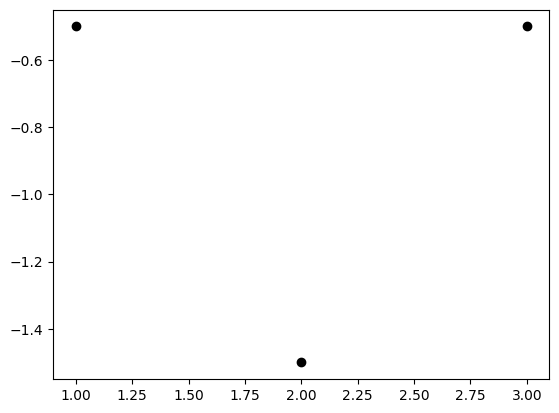

In [17]:
#diagonalizzazione singoli blocchi
J1,J2=1,1
for N in range(1,L):
    HN = build_HN(L,N,J1,J2)
    vals, vecs = eigsh(HN, k=2, which='SA') #LM Largest Magnitude, SM Smallest Magnitud, LA Largest Algebric, SA Smallest Algebric
    print(N, f"primo autoval={vals[0]}, secondo autoval={vals[1]}")
    plt.plot(N, vals[0], "o", color="black")

In [51]:
theta = [0, np.pi/4, np.pi/2, 3/4*np.pi, np.pi]
for l in range(len(theta)):
    J1 = np.sin(theta[l])
    J2 = np.cos(theta[l])
    for i in range(dim):
        H = Hamiltonian(J1,J2,i)
        for value,j in H:
            row.append(i)      
            col.append(j)      
            data.append(value) #appende value in posizione (i,j) 
    sparse_matrix = csr_matrix((data,(row,col)),shape=(dim,dim))
    vals, vecs = eigsh(sparse_matrix, k=30, which='SA') #LM Largest Magnitude, SM Smallest Magnitud, LA Largest Algebric, SA Smallest Algebric
    eigen_values = np.array(vals)
    plt.plot(eigen_values, 'o', label=f"J1={round(J1,2)}, J2={round(J2,2)}")
plt.legend()
plt.show()
    

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [29]:
theta = [i*np.pi/2 for i in range(8)]

[0.0, 1.5707963267948966, 3.141592653589793, 4.71238898038469, 6.283185307179586, 7.853981633974483, 9.42477796076938, 10.995574287564276]


0
1
2
3
4
5
6
7


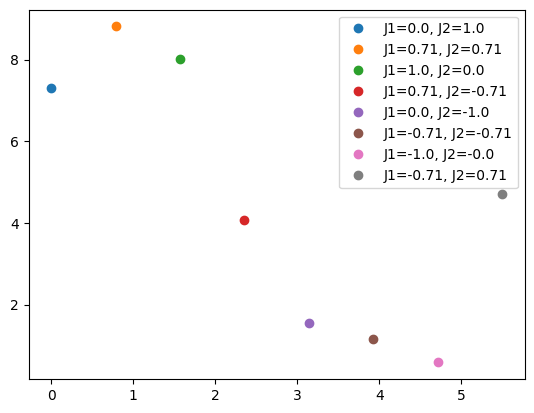

In [36]:
theta = [i*np.pi/4 for i in range(8)]
gap = []
for l in range(len(theta)):
    print(l)
    J1 = np.sin(theta[l])
    J2 = np.cos(theta[l])
    for i in range(dim):
        H = Hamiltonian(J1,J2,i)
        for value,j in H:
            row.append(i)      
            col.append(j)      
            data.append(value) #appende value in posizione (i,j) 
    sparse_matrix = csr_matrix((data,(row,col)),shape=(dim,dim))
    vals, vecs = eigsh(sparse_matrix, k=2, which='SA') #LM Largest Magnitude, SM Smallest Magnitud, LA Largest Algebric, SA Smallest Algebric
    eingen_values = np.array(vals)
    gap.append(eingen_values[1]-eingen_values[0])
    plt.plot(theta[l], gap[l], 'o', label=f"J1={round(J1,2)}, J2={round(J2,2)}")
plt.legend()
plt.show()